In [1]:
%pip install scikit-learn mlflow category-encoders pandas numpy matplotlib seaborn joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **Importaciones**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"]     = 100
sns.set_theme(style="whitegrid")



# **Cargar datos**

In [3]:
X = pd.read_parquet("../data/processed/features_processed.parquet")
y = pd.read_parquet("../data/processed/targets_binary.parquet").iloc[:, 0]

print("===== DATOS PROCESADOS =====")
print(f"Shape X:  {X.shape}")
print(f"Columnas: {list(X.columns)}")
print(f"\nVariable respuesta — income:")
print(f"  0 (<=50K): {(y==0).sum()} personas ({round((y==0).mean()*100,1)}%)")
print(f"  1 (>50K):  {(y==1).sum()} personas ({round((y==1).mean()*100,1)}%)")
X.head()

===== DATOS PROCESADOS =====
Shape X:  (48842, 12)
Columnas: ['age', 'hours-per-week', 'workclass', 'occupation', 'marital-status', 'relationship', 'race', 'sex', 'native-country', 'education', 'capital-gain', 'capital-loss']

Variable respuesta — income:
  0 (<=50K): 37155 personas (76.1%)
  1 (>50K):  11687 personas (23.9%)


,age,hours-per-week,workclass,occupation,marital-status,relationship,race,sex,native-country,education,capital-gain,capital-loss
0,0.025996,-0.034087,7.0,1.0,4.0,1.0,4.0,1.0,39.0,0.412835,7.684784,0.0
1,0.828308,-2.213032,6.0,4.0,2.0,0.0,4.0,1.0,39.0,0.412835,0.000000,0.0
2,-0.046942,-0.034087,4.0,6.0,0.0,1.0,4.0,1.0,39.0,0.158578,0.000000,0.0
3,1.047121,-0.034087,4.0,6.0,2.0,0.0,2.0,1.0,39.0,0.050773,0.000000,0.0
4,-0.776316,-0.034087,4.0,10.0,2.0,5.0,2.0,0.0,5.0,0.412835,0.000000,0.0


## **Interpretación de los Datos Procesados**

El dataset procesado contiene **48,842 registros** y **12 variables predictoras** para predecir si una persona gana más o menos de $50,000 USD anuales, donde el 76.1% gana <=50K y el 23.9% gana >50K.

### Variables y transformaciones aplicadas

- **age y hours-per-week** → normalizadas con StandardScaler. 
  Los valores negativos significan que están por debajo del promedio.
- **workclass, occupation, marital-status, relationship, race, sex, native-country** 
  → convertidas de texto a números con OrdinalEncoder (ejemplo: Private = 4.0).
- **education** → transformada con Target Encoding, donde el valor representa 
  la probabilidad de ganar >50K según el nivel educativo.
- **capital-gain y capital-loss** → suavizadas con transformación logarítmica 
  para reducir el efecto de valores extremos.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("===== DIVISION TRAIN / TEST =====")
print(f"Train: {X_train.shape[0]} filas ({round(len(X_train)/len(X)*100,1)}%)")
print(f"Test:  {X_test.shape[0]} filas ({round(len(X_test)/len(X)*100,1)}%)")
print(f"\nDistribucion en train:")
print(f"  <=50K: {(y_train==0).sum()} | >50K: {(y_train==1).sum()}")
print(f"Distribucion en test:")
print(f"  <=50K: {(y_test==0).sum()} | >50K: {(y_test==1).sum()}")

===== DIVISION TRAIN / TEST =====
Train: 39073 filas (80.0%)
Test:  9769 filas (20.0%)

Distribucion en train:
  <=50K: 29724 | >50K: 9349
Distribucion en test:
  <=50K: 7431 | >50K: 2338


El dataset fue dividido en **39,073 registros para entrenamiento (80%)** y **9,769 registros para prueba (20%)**, utilizando estratificación para garantizar que la proporción de clases se mantuviera constante en ambos conjuntos. En el conjunto de entrenamiento hay **29,724 personas que ganan <=50K** y **9,349 que ganan >50K**, mientras que en el conjunto de prueba hay **7,431 y 2,338** respectivamente, asegurando que el modelo aprenda y sea evaluado con una 
representación proporcional de ambas clases.

# **Compararción de los 3 modelos**

In [26]:
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,
                                               class_weight="balanced"),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42,
                                                   class_weight="balanced"),
    "Gradient Boosting":   GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                                       max_depth=4, random_state=42),
}

cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = []

print("===== COMPARACION DE MODELOS CON CLASS_WEIGHT BALANCED =====\n")
for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
    resultados.append({
        "Modelo":   nombre,
        "F1 Media": round(scores.mean(), 4),
        "F1 Std":   round(scores.std(), 4),
    })
    print(f"  {nombre:<25} F1: {scores.mean():.4f} +/- {scores.std():.4f}")

df_resultados = pd.DataFrame(resultados).sort_values("F1 Media", ascending=False)
print(f"\n Mejor modelo: {df_resultados.iloc[0]['Modelo']}")
df_resultados

===== COMPARACION DE MODELOS CON CLASS_WEIGHT BALANCED =====

  Logistic Regression       F1: 0.7176 +/- 0.0027
  Random Forest             F1: 0.7849 +/- 0.0034
  Gradient Boosting         F1: 0.8143 +/- 0.0043

 Mejor modelo: Gradient Boosting


,Modelo,F1 Media,F1 Std
2,Gradient Boosting,0.8143,0.0043
1,Random Forest,0.7849,0.0034
0,Logistic Regression,0.7176,0.0027


Se evaluaron tres modelos mediante validación cruzada de 5 pliegues con la métrica **F1-macro**, siendo **Gradient Boosting (0.8143)** el de mejor desempeño, seguido de Random Forest (0.7849) y Logistic Regression (0.7176), por lo que se selecciona Gradient Boosting como modelo final al demostrar la mayor capacidad para predecir correctamente ambas clases de ingreso.

# **Gráfico comparación de modelos**

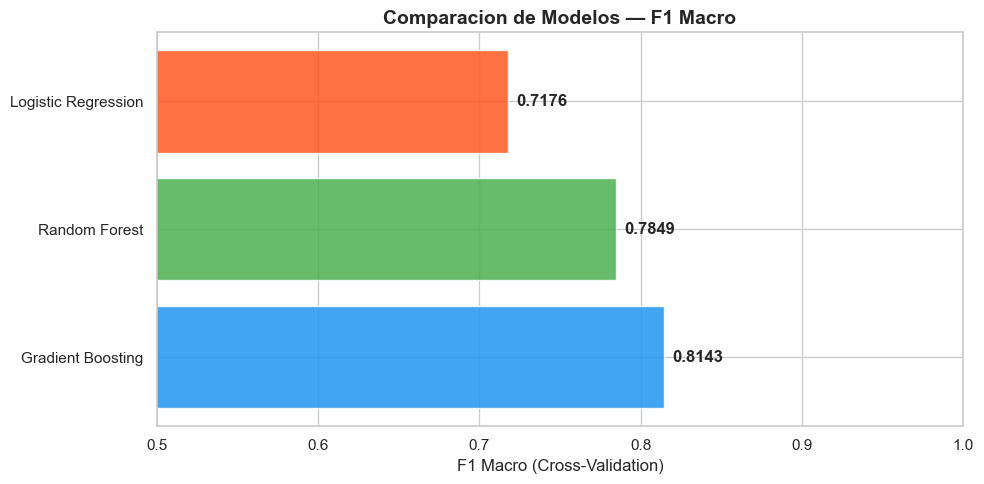

In [33]:
plt.figure(figsize=(10, 5))
colores = ["#2196F3", "#4CAF50", "#FF5722"]
bars    = plt.barh(df_resultados["Modelo"], df_resultados["F1 Media"],
                   color=colores, alpha=0.85)
plt.xlabel("F1 Macro (Cross-Validation)")
plt.title("Comparacion de Modelos — F1 Macro", fontsize=14, fontweight="bold")
plt.xlim(0.5, 1.0)
for bar, val in zip(bars, df_resultados["F1 Media"]):
    plt.text(val + 0.005, bar.get_y() + bar.get_height()/2,
             str(val), va="center", fontweight="bold")
plt.tight_layout()
plt.show()

El gráfico confirma que **Gradient Boosting (0.8143)** es el modelo con mayor capacidad predictiva, superando a Random Forest (0.7849) por 0.03 puntos y a Logistic Regression (0.7176) por 0.10 puntos, siendo este último el de menor desempeño al no capturar adecuadamente las relaciones no lineales del dataset. Con base en estos resultados, Gradient Boosting es seleccionado como el modelo final para predecir el ingreso anual.

# **Entrenar mejor modelo**

In [28]:
mejor_modelo = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

# Calcular pesos manualmente para manejar desbalance
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Entrenar con pesos
mejor_modelo.fit(X_train, y_train, sample_weight=sample_weights)

y_pred  = mejor_modelo.predict(X_test)
y_proba = mejor_modelo.predict_proba(X_test)[:, 1]

print("===== METRICAS EN TEST (con manejo de desbalance) =====")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  F1 Macro:  {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"\n{classification_report(y_test, y_pred, target_names=['<=50K', '>50K'])}")

===== METRICAS EN TEST (con manejo de desbalance) =====
  Accuracy:  0.8389
  F1 Macro:  0.8024
  AUC-ROC:   0.9289

              precision    recall  f1-score   support

       <=50K       0.95      0.83      0.89      7431
        >50K       0.62      0.86      0.72      2338

    accuracy                           0.84      9769
   macro avg       0.78      0.84      0.80      9769
weighted avg       0.87      0.84      0.85      9769



El modelo **Gradient Boosting** alcanzó un **Accuracy de 0.8389**, un **F1-macro de 0.8024** y un **AUC-ROC de 0.9289** sobre el conjunto de prueba, lo que indica una capacidad de clasificación sobresaliente. Para la clase 
**<=50K**, el modelo logró una precisión de 0.95 y un recall de 0.83, reflejando que identifica con alta confiabilidad a las personas de menores ingresos. Para la clase **>50K**, la precisión fue de 0.62 y el recall de 0.86, lo que significa que el modelo detecta el 86% de las personas de altos ingresos aunque con más falsos positivos, resultado esperado dado el desbalance del dataset. En conjunto, el **AUC-ROC de 0.9289** confirma que el modelo tiene una excelente capacidad para distinguir entre ambas clases.

# **Matriz de confusión**

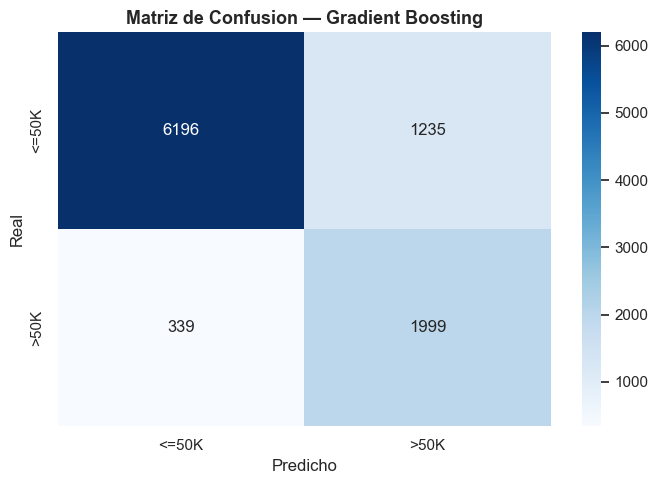

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["<=50K", ">50K"],
            yticklabels=["<=50K", ">50K"])
plt.title("Matriz de Confusion — Gradient Boosting", fontsize=13, fontweight="bold")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

La matriz de confusión revela que el modelo clasificó correctamente **6,196 personas que ganan <=50K** y **1,999 personas que ganan >50K**, mientras que cometió **1,235 falsos positivos** (personas predichas como >50K que realmente ganan <=50K) y solo **339 falsos negativos** (personas predichas como <=50K que realmente ganan >50K). El bajo número de falsos negativos (339) es particularmente valioso en este contexto, ya que el modelo tiene una alta capacidad para detectar correctamente a las personas de altos ingresos, que representan la clase minoritaria del dataset.

# **Curva ROC**

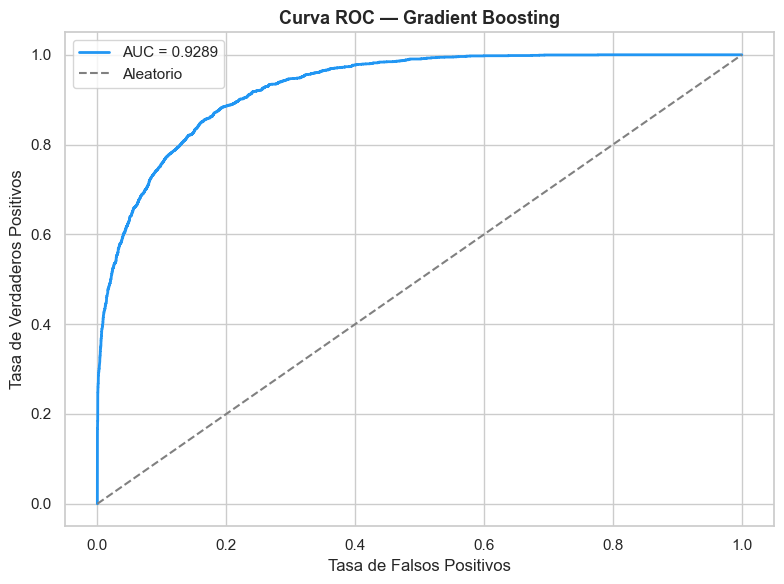

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc         = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#2196F3", lw=2, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Aleatorio")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC — Gradient Boosting", fontsize=13, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()


La curva ROC del modelo **Gradient Boosting** alcanza un **AUC de 0.9289**, muy superior a la línea diagonal punteada que representa un clasificador aleatorio (AUC = 0.5), lo que confirma la excelente capacidad discriminativa del modelo. La curva asciende de forma pronunciada hacia la esquina superior izquierda desde el inicio, indicando que el modelo logra una **alta tasa de verdaderos positivos con una tasa de falsos positivos muy baja**, es decir, identifica correctamente a las personas de altos ingresos sin comprometer significativamente la clasificación 
de las personas de bajos ingresos. Un AUC de 0.9289 se considera **sobresaliente** en problemas de clasificación binaria.

# **Importancia de variables**

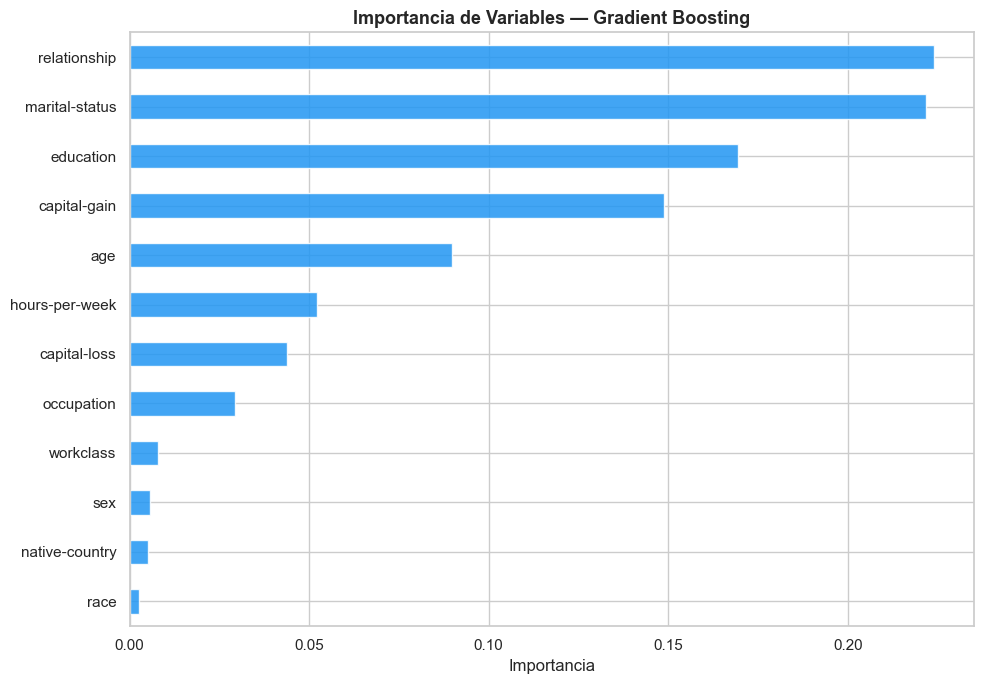


Top 5 variables mas importantes:
relationship      0.223907
marital-status    0.221658
education         0.169292
capital-gain      0.148735
age               0.089868
dtype: float64


In [34]:
importancias = pd.Series(
    mejor_modelo.feature_importances_,
    index=X.columns
).sort_values(ascending=True)

plt.figure(figsize=(10, 7))
importancias.plot(kind="barh", color="#2196F3", alpha=0.85)
plt.title("Importancia de Variables — Gradient Boosting", fontsize=13, fontweight="bold")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

print("\nTop 5 variables mas importantes:")
print(importancias.sort_values(ascending=False).head(5))

El gráfico revela que las variables más determinantes para predecir el ingreso anual son **relationship (0.23)** y **marital-status (0.22)**, lo que sugiere que el estado civil y el rol familiar tienen una influencia decisiva sobre los ingresos, posiblemente porque reflejan estructuras socioeconómicas del hogar. Le siguen en importancia **education (0.17)** y **capital-gain (0.15)**, confirmando que el nivel educativo y las ganancias de capital son factores clave para superar el umbral de $50,000 USD anuales. Variables como **age (0.09)** y **hours-per-week (0.05)** tienen una influencia moderada, mientras que **race, native-country y sex** presentan una importancia casi nula, 
lo que indica que el modelo no depende de características demográficas sensibles para realizar sus predicciones.

In [32]:
from pathlib import Path
import json

Path("../models").mkdir(exist_ok=True)
Path("../artifacts").mkdir(exist_ok=True)

joblib.dump(mejor_modelo, "../models/model.pkl")

metrics = {
    "accuracy": round(float(accuracy_score(y_test, y_pred)), 4),
    "f1_macro": round(float(f1_score(y_test, y_pred, average="macro")), 4),
    "auc_roc":  round(float(roc_auc_score(y_test, y_proba)), 4),
}
with open("../artifacts/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print(" Modelo guardado en models/model.pkl")
print(" Metricas guardadas en artifacts/metrics.json")
print(f"\nMetricas finales:")
for k, v in metrics.items():
    print(f"  {k}: {v}")

 Modelo guardado en models/model.pkl
 Metricas guardadas en artifacts/metrics.json

Metricas finales:
  accuracy: 0.8389
  f1_macro: 0.8024
  auc_roc: 0.9289


Se obtuvo un **Accuracy de 0.8389**, un **F1-macro de 0.8024** y un **AUC-ROC de 0.9289**, resultados que confirman que el modelo tiene una capacidad predictiva sobresaliente para clasificar correctamente si una persona gana más o menos de $50,000 USD anuales, siendo el AUC-ROC de 0.9289 el indicador más sólido de su excelente poder discriminativo entre ambas clases.